Dataset Loaded! Shape: (494021, 42)
Missing values: 0
Training set: (395216, 41) Test set: (98805, 41)
Accuracy: 0.999787460148778

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19456
           1       1.00      1.00      1.00     79349

    accuracy                           1.00     98805
   macro avg       1.00      1.00      1.00     98805
weighted avg       1.00      1.00      1.00     98805



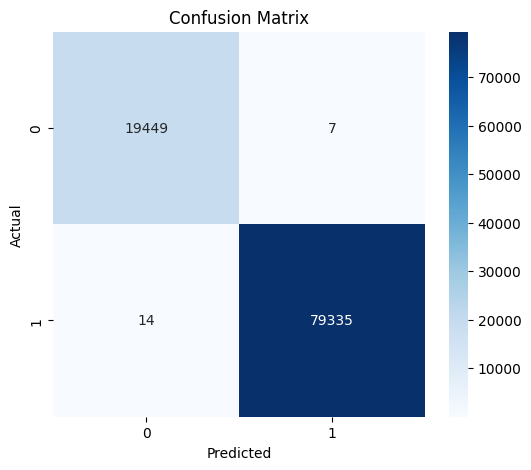

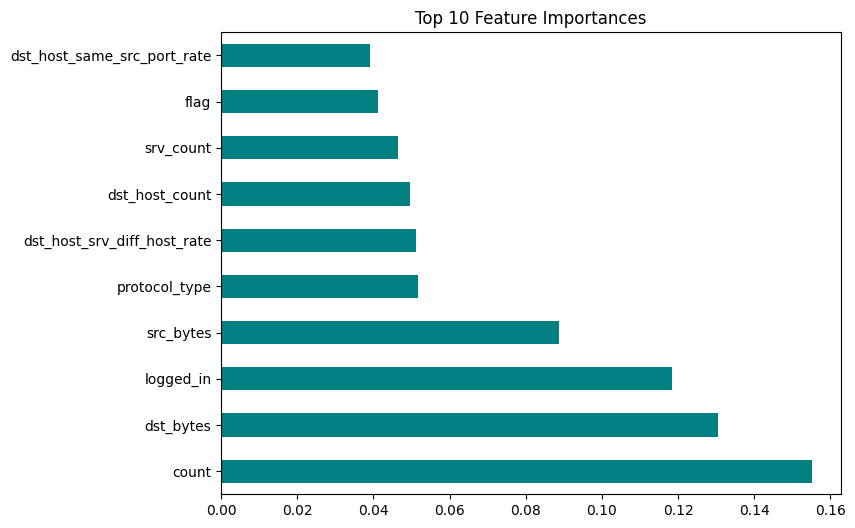

Model saved as ids_model.pkl


In [1]:

!pip install scikit-learn pandas matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# You can also upload UNSW-NB15 later
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
column_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files",
    "num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
    "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label"
]

df = pd.read_csv(url, names=column_names, header=None)
print("Dataset Loaded! Shape:", df.shape)
df.head()

# Encode categorical columns
cat_cols = ["protocol_type", "service", "flag"]
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Convert label to binary: normal vs attack
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# Check for missing values
print("Missing values:", df.isnull().sum().sum())

# Scale features
X = df.drop("label", axis=1)
y = df["label"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set:", X_train.shape, "Test set:", X_test.shape)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

feat_importances = pd.Series(model.feature_importances_, index=df.drop("label", axis=1).columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(8,6), color='teal')
plt.title("Top 10 Feature Importances")
plt.show()

import joblib
joblib.dump(model, "ids_model.pkl")
print("Model saved as ids_model.pkl")


Dataset Loaded! Shape: (494021, 42)
Missing values: 0
Training set: (395216, 41) Test set: (98805, 41)
Accuracy: 0.9997672182581853

Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     78292
       Probe       1.00      0.99      1.00       822
         R2L       1.00      0.97      0.98       225
         U2R       0.80      0.80      0.80        10
      normal       1.00      1.00      1.00     19456

    accuracy                           1.00     98805
   macro avg       0.96      0.95      0.96     98805
weighted avg       1.00      1.00      1.00     98805



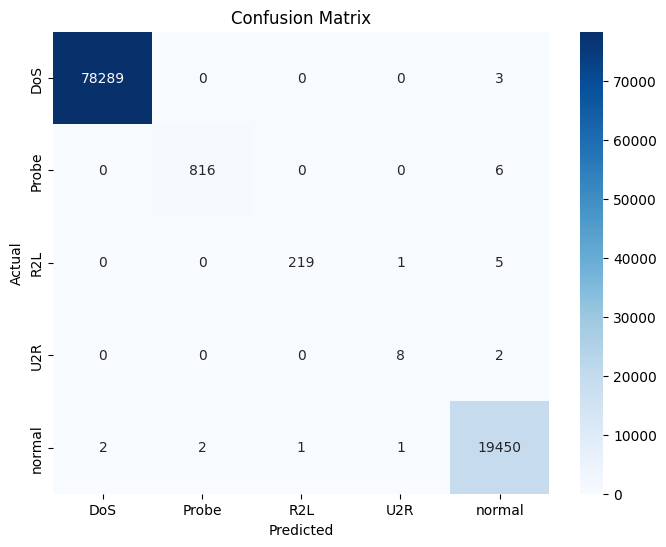

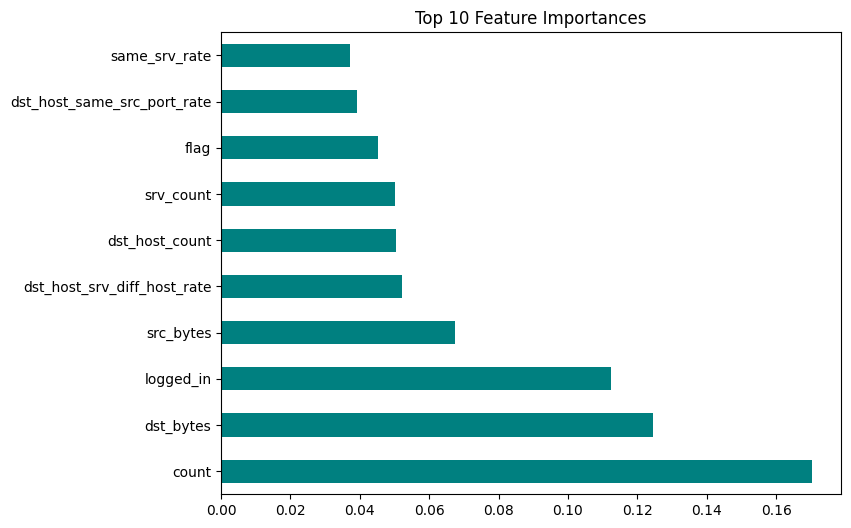

Model saved as ids_multiclass_model.pkl
Predictions saved to IDS_PowerBI_Results.csv


In [2]:
# =========================
# 1️⃣ Setup & Libraries
# =========================
!pip install scikit-learn pandas matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib

# =========================
# 2️⃣ Load Dataset (KDD99 10% sample)
# =========================
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
column_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files",
    "num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
    "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label"
]

df = pd.read_csv(url, names=column_names, header=None)
print("Dataset Loaded! Shape:", df.shape)
df.head()

# =========================
# 3️⃣ Preprocessing
# =========================
# Encode categorical columns
cat_cols = ["protocol_type", "service", "flag"]
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Map attack types to broader categories (optional: multi-class)
def categorize_attack(label):
    if label == 'normal.':
        return 'normal'
    elif label in ['neptune.', 'smurf.', 'back.', 'teardrop.', 'pod.', 'land.', 'apache2.', 'udpstorm.', 'processtable.']:
        return 'DoS'
    elif label in ['satan.', 'ipsweep.', 'nmap.', 'portsweep.', 'mscan.', 'saint.']:
        return 'Probe'
    elif label in ['ftp_write.', 'guess_passwd.', 'imap.', 'phf.', 'multihop.', 'warezmaster.', 'warezclient.', 'spy.', 'named.']:
        return 'R2L'
    elif label in ['buffer_overflow.', 'loadmodule.', 'rootkit.', 'perl.', 'sqlattack.', 'xterm.', 'ps.']:
        return 'U2R'
    else:
        return 'other'

df['label_cat'] = df['label'].apply(categorize_attack)

# Check missing values
print("Missing values:", df.isnull().sum().sum())

# Features and target
X = df.drop(["label","label_cat"], axis=1)
y = df['label_cat']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# 4️⃣ Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set:", X_train.shape, "Test set:", X_test.shape)

# =========================
# 5️⃣ Model Training
# =========================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# =========================
# 6️⃣ Evaluation
# =========================
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# =========================
# 7️⃣ Feature Importance
# =========================
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(8,6), color='teal')
plt.title("Top 10 Feature Importances")
plt.show()

# =========================
# 8️⃣ Save Model & Predictions for Power BI
# =========================
joblib.dump(model, "ids_multiclass_model.pkl")
print("Model saved as ids_multiclass_model.pkl")

# Save test results for Power BI
results_df = pd.DataFrame(X_test, columns=X.columns)
results_df['Actual'] = y_test.values
results_df['Predicted'] = y_pred
results_df.to_csv("IDS_PowerBI_Results.csv", index=False)
print("Predictions saved to IDS_PowerBI_Results.csv")
